<a href="https://colab.research.google.com/github/sangar-si/ImageSegmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and extract dataset

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Data/kaggle.json /root/.kaggle/kaggle.json
!kaggle competitions download -c carvana-image-masking-challenge
!cp /content/drive/MyDrive/Data/extract.sh /content/extract.sh
!sh extract.sh

In [ ]:
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
from torch.optim import Adam, SGD, RMSprop
import torch
from torch.utils.data import Dataset, random_split, DataLoader

import matplotlib.pylab as plt
import numpy as np
import cv2
from os import listdir
from os.path import splitext
from pathlib import Path
from PIL import Image
from tqdm import tqdm

In [ ]:
df = pd.read_csv('metadata.csv')

# Dataset class

In [ ]:
images_dir = "/content/train"
mask_dir = "/content/train_masks"
img_path = Path(images_dir)

class LoadData(Dataset):
  def __init__(self,img_path, mask_path, scale = 1):
    self.img_path = Path(img_path)
    self.mask_path = Path(mask_path)
    self.scale = scale
    self.img_id = [splitext(f)[0] for f in listdir(img_path) if not f.startswith(".")]

  def __len__(self):
    return len(self.img_id)

  def __getitem__(self, idx):
    name = self.img_id[idx]
    mask_file = list(self.mask_path.glob(name +"_mask" +'.*'))
    img_file = list(self.img_path.glob(name+'.*'))
    mask = self.load(mask_file[0])
    img = self.load(img_file[0])
    mask = self.preprocess(img = mask, scale = self.scale, is_mask = True)
    img = self.preprocess(img = img, scale = self.scale, is_mask = False)

    return {
        'image': torch.as_tensor(img.copy()).float().contiguous(),
        'mask' : torch.as_tensor(mask.copy()).long().contiguous()
    }
  @classmethod
  def load(cls,filename):
    return Image.open(filename)

  @classmethod
  def preprocess(cls,img,scale,is_mask):
    w, h = img.size
    new_w, new_h = int(w * scale), int(h * scale)
    img = img.resize((new_w, new_h), resample=Image.NEAREST if is_mask else Image.BICUBIC)
    img_arr = np.asarray(img)
    if img_arr.ndim == 2 and not is_mask:
      img_arr = img_arr[np.newaxis, ...]
    elif not is_mask:
      img_Arr = img_arr.transpose((2,0,1))
    if not is_mask:
      img_arr = img_arr / 255
    return img_arr


In [ ]:
ds = LoadData(img_path = images_dir, scale = 0.5, mask_path= mask_dir)

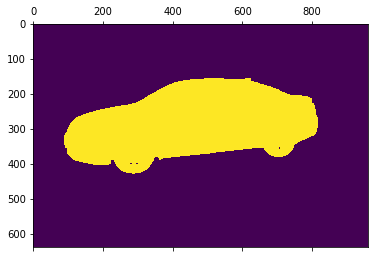

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(np.asarray(ds[1]['mask']))
plt.show()

# UNet model definition

In [ ]:
#Model

class EnBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.convBlock = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(), nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU())
  def forward(self, x):
    return self.convBlock(x)

class Encoder(nn.Module):
  def __init__(self, chnls = (3,64,128,256,512,1024)):
    super().__init__()
    self.en_blocks = nn.ModuleList([EnBlock(chnls[i], chnls[i+1]) for i in range(len(chnls)-1)])
    self.pool = nn.MaxPool2d(2)

  def forward(self,x):
    enc_features = []
    for block in self.en_blocks:
      x = block(x)
      enc_features.append(x)
      x = self.pool(x)
    return enc_features

class DeBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.upConv = nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
    self.decBlock = EnBlock(in_ch, out_ch)

  def crop(self, enc_features, x):
    _,_,h,w = x.shape
    enc_features   = torchvision.transforms.CenterCrop([h, w])(enc_features) 
    return x, enc_features

  def pad(self, enc_features, x):
    _,_,hx,wx = x.shape
    _,_,henc,wenc = enc_features.shape
    hdiff = henc - hx
    wdiff = wenc - wx
    x = F.pad(x, [wdiff // 2, wdiff - wdiff // 2,
                        hdiff // 2, hdiff - hdiff // 2])
    return x, enc_features

  def forward(self, x, enc_features):
    x = self.upConv(x)
    # x, enc_f = self.crop(enc_features,x)
    x, enc_f = self.pad(enc_features, x)
    x = torch.cat([x, enc_f], dim=1)
    x = self.decBlock(x)
    return x

class Decoder(nn.Module):
  def __init__(self, chnls = (1024, 512, 256, 128, 64)):
    super().__init__()
    self.chnls = chnls
    self.de_blocks = nn.ModuleList([DeBlock(chnls[i], chnls[i+1]) for i in range(len(chnls)-1)])

  def forward(self,x,enc_features):
    for i in range(len(self.chnls)-1):
      x = self.de_blocks[i](x, enc_features[i])
    return x

class UNet(nn.Module):
  def __init__(self, enc_chnls = (3,64,128,256,512,1024), dec_chnls = (1024, 512, 256, 128, 64), num_class = 1, retain_dim=False, out_sz=(572,572)):
    super().__init__()
    self.encoder = Encoder(enc_chnls)
    self.decoder = Decoder(dec_chnls)
    self.head = nn.Conv2d(dec_chnls[-1],num_class, 1)
    self.retain_dim = retain_dim
    self.out_sz = out_sz
  
  def forward(self,x):
    enc_features = self.encoder(x)
    out = self.decoder(enc_features[::-1][0], enc_features[::-1][1:])
    out = self.head(out)
    if self.retain_dim:
      out = F.interpolate(out, self.out_sz)
    return out

class CEDiceLoss(nn.Module):
  def __init__(self, weights = None, size_average = True):
    super(CEDiceLoss,self).__init__()

  def dice(self, mask_pred, mask_true, smooth=1e-8):
    mask_pred = F.softmax(mask_pred).float()
    mask_true = F.one_hot(mask_true, 2).permute(2, 0, 1).float()
    # print(mask_pred.shape)
    # print(mask_true.shape)
    mask_pred = mask_pred.reshape(-1)
    mask_true = mask_true.reshape(-1)
    intersection = (mask_pred * mask_true).sum()
    dice_loss = 1 - (2 * intersection + smooth) / (mask_pred.sum() + mask_true.sum() + smooth)
    return dice_loss

  def forward(self, mask_pred, mask_true, smooth = 1e-8):
    CELoss = F.cross_entropy(mask_pred, mask_true, reduction='mean')
    dice_sum = 0
    for i in range(mask_pred.shape[0]):
      dice_sum+= self.dice(mask_pred[i,...], mask_true[i,...])
    dice_loss = dice_sum/mask_pred.shape[0]
    # mask_pred = F.softmax(mask_pred)
    # mask_pred = mask_pred.view(-1)
    # mask_true = mask_true.view(-1)
    # intersection = (mask_pred * mask_true).sum()
    # dice_loss = 1 - (2 * intersection + smooth) / (mask_pred.sum() + mask_true.sum() + smooth)
    return CELoss+dice_loss

def dice_score(mask_pred, mask_true, smooth = 1e-8):
  dice_sum = 0.0
  for i in range(mask_pred.shape[0]):
    m_pred = mask_pred[i,...]
    m_true = mask_true[i,...]
    m_pred = F.one_hot(m_pred.argmax(dim = 0), 2).permute(2,0,1).float().reshape(-1)
    m_true = F.one_hot(m_true,2).permute(2,0,1).float().reshape(-1)
    intersection = (m_pred * m_true).sum()
    dice_sum += 1 - (2 * intersection + smooth) / (m_pred.sum() + m_true.sum() + smooth)
  return dice_sum/mask_pred.shape[0]




# Train, eval and predict function

In [ ]:
def train(net, epochs, batch_size, lr, device, scale, val_percent, amp, save_checkpoint = True):
  images_dir = "/content/train"
  mask_dir = "/content/train_masks"
  img_path = Path(images_dir)
  ds = LoadData(img_path = images_dir, scale = scale, mask_path= mask_dir)

  n_val = int(len(ds) * val_percent)
  n_train = len(ds) - n_val
  train_set, val_set = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(0))

  loader_args = dict(batch_size = batch_size, num_workers = 4, pin_memory = True)
  train_loader = DataLoader(train_set, shuffle=True, **loader_args)
  val_loader = DataLoader(val_set, shuffle=False, drop_last = True, **loader_args) 

  optimizer = RMSprop(net.parameters(), lr = lr, weight_decay = 1e-8, momentum = 0.9)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
  # criterion = nn.CrossEntropyLoss()
  criterion = CEDiceLoss()
  global_step = 0
  epoch_loss = 0
  val_score = {}
  for epoch in range(epochs):
    net.train()
    with tqdm(total = n_train, desc = f'Epoch {epoch + 1}/{epochs}', unit = 'img') as pbar:
      for batch in train_loader:
        imgs = batch['image']
        masks = batch['mask']
        imgs = imgs.to(device=device, dtype = torch.float32)
        imgs = torch.permute(imgs,(0,3,1,2))
        masks = masks.to(device=device, dtype = torch.long)

        with torch.cuda.amp.autocast(enabled = amp):
          masks_pred = net(imgs)
          # loss = criterion(masks_pred, masks)\
          #                  + dice_loss(F.softmax(masks_pred, dim=1).float(),
          #                              F.one_hot(masks, net.n_classes).permute(0, 3, 1, 2).float(),
          #                              multiclass=True)
          loss = criterion(masks_pred,masks)
        optimizer.zero_grad(set_to_none = True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

        pbar.update(imgs.shape[0])
        global_step +=1
        epoch_loss += loss.item()
        pbar.set_postfix(**{'loss (batch)': loss.item()})

        #Eval
        div_step = (n_train//(10*batch_size))
        if div_step > 0:
          if global_step % div_step == 0:
            val_score = evaluate(net, val_loader, device)
            print("Val score is ", val_score)
            scheduler.step(val_score)
    if save_checkpoint:
      try:
        torch.save(net.state_dict(),"unet"+str(epoch)+".pth")
      except:
        print("Save failed")

def evaluate(net, data_loader, device):
  net.eval()
  dice_score_value = 0 
  for batch in tqdm(data_loader, total = len(data_loader), desc = 'Validation round', unit = 'batch'):
    imgs, masks = batch['image'], batch['mask']
    imgs = imgs.to(device=device, dtype = torch.float32)
    imgs = torch.permute(imgs,(0,3,1,2))
    masks = masks.to(device=device, dtype = torch.long)
    # masks = F.one_hot(masks, 2).permute(0, 3, 1, 2).float()

    with torch.no_grad():
      mask_pred = net(imgs)
      dice_score_value += dice_score(mask_pred, masks)
    net.train()
  return dice_score_value/len(data_loader)


In [ ]:
def predict(net, image, device):
  net.eval()
  image = image.to(device = device, dtype = torch.float32)

  image = image[None,:]
  image = torch.permute(image, (0,3,1,2))

  with torch.no_grad():
    m_pred = net(image)
  m_pred = m_pred[0,...].argmax(dim=0).to(device = 'cpu', dtype = torch.long)
  plt.matshow(np.asarray(m_pred))
  plt.show()
  return m_pred

def display_mask(mask):
  plt.matshow(np.asarray(mask))
  plt.show()

In [ ]:
net = UNet(num_class=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device = device)

NameError: ignored

In [ ]:
train(net=net, epochs = 3, batch_size = 5, lr = 0.00001, device = device, scale = 0.5, val_percent = 10/100, amp = False)

In [ ]:
val_loader = DataLoader(val_set, shuffle=False, drop_last = True, **loader_args)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_image = val_set[10]
test_img = test_image['image']
test_mask = test_image['mask']
m_pred = predict(net, test_img, device)
display_mask(test_mask)